# Application benchmarks: Single Node Performance Comparison

Comparison the single-node performance of three different application benchmarks across a variety of architectures.

This notebook accompanies the [Performance of HPC Application Benchmarks across UK National HPC services: single node performance](https://github.com/hpc-uk/archer-benchmarks/tree/master/reports/single_node/index.md) report.

## Import required modules for results analysis

In [29]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (12,6)
import seaborn as sns
sns.set_style("white", {"font.family": "serif"})
from scipy import stats
marker_a = ['x','o','^','+','d','s','v','x','o']

In [30]:
import sys
sys.path.append('../python-modules')
from utilities import filemanip, sysinfo

## System details

In [31]:
sysdetails = sysinfo.getdetails('../systems.yaml')

## Peak floating point performance

In this section we calculate the peak floating point performance for each of the systems. CPU FLOPS are computed as
(number of cores used) &times; (single precision FLOPS per cycle) &times; (frequency). See below for values used for the different systems.

In [32]:
systems = ['ARCHER','Athena','Cirrus','CSD3-Skylake','Isambard','Tesseract','Thomas','CSD3-GPU','JADE']
peak_fp = {}
vec_width = {}
flops = {}

formath = "{:>15s} {:>20s} {:>20s} {:>20s}"
formatp = "{:>15s} {:>20d} {:>20d} {:>20.1f}"
print("Peak single precision (SP) floating point performance:\n")
print(formath.format('System', 'CPU Vector Width', 'CPU SP FLOPS/cycle', 'Peak CPU SP FLOP/s'))
print(formath.format('======', '================', '==================', '=================='))

# Calculate CPU SP FP performance (GFLOP/s): cores * ops/cycle * freq.
for system in systems:
    sysdict = sysdetails[system]
    vec_width[system] = sysdict['VWidth']
    flops[system] = sysdict['FLOPS']
    peak_fp[system] = sysdict['PCores'] * sysdict['PPerNode'] * sysdict['FLOPS'] * sysdict['PFreq']
    print(formatp.format(sysdict['Name'], vec_width[system], flops[system], peak_fp[system]))


Peak single precision (SP) floating point performance:

         System     CPU Vector Width   CPU SP FLOPS/cycle   Peak CPU SP FLOP/s
         ======     ================   ==================   ==================
         ARCHER                  128                   16               1036.8
         Athena                  256                   32               2150.4
         Cirrus                  256                   32               2419.2
  Peta4-Skylake                  512                   64               5324.8
       Isambard                  128                   16               2252.8
      Tesseract                  512                   32               1612.8
         Thomas                  256                   32               1612.8
    Wilkes2-GPU                  256                   32                844.8
           JADE                  256                   32               3072.0


## Peak memory performance
We define the peak memory performance both in terms of the peak bandwidth measured using the StarSTREAM Triad benchmark (part of the HPC Challenge suite) and in terms of the number of memory channels available per socket. Note, these values are for the CPU systems only.

In [33]:
# Per-core memory bandwidth from StarSTREAM Triad (GB/s)
peak_bw = {}
peak_bw['ARCHER'] = 3.036
peak_bw['Athena'] = 3.304
peak_bw['CSD3-Skylake'] = 4.508
peak_bw['Cirrus'] = 2.718
peak_bw['Isambard'] = 3.461
peak_bw['Tesseract'] = 5.181
peak_bw['Thomas'] = 3.694


# Per-socket memory channels
systems = ['ARCHER','Athena','Cirrus','CSD3-Skylake','Isambard','Tesseract','Thomas','CSD3-GPU','JADE']
channels = {}

formath = "{:>15s} {:>20s} {:>40s}"
formatp = "{:>15s} {:>20d} {:>40.3f}"
print("Memory characteristics (memory bandwidth not available for GPU systems):\n")
print(formath.format('System', 'Memory Channels', 'Per-core Triad Memory Bandwidth (GB/s)'))
print(formath.format('======', '===============', '======================================'))

for system in systems:
    sysdict = sysdetails[system]
    channels[system] = sysdict['MChannels']
    print(formatp.format(sysdict['Name'], channels[system], peak_bw.get(system,0)))


Memory characteristics (memory bandwidth not available for GPU systems):

         System      Memory Channels   Per-core Triad Memory Bandwidth (GB/s)
         ======      ===============   ======================================
         ARCHER                    4                                    3.036
         Athena                    4                                    3.304
         Cirrus                    4                                    2.718
  Peta4-Skylake                    6                                    4.508
       Isambard                    8                                    3.461
      Tesseract                    6                                    5.181
         Thomas                    4                                    3.694
    Wilkes2-GPU                    4                                    0.000
           JADE                    4                                    0.000


## CASTEP: Al Slab benchmark

Details of the Al Slab benchmark can be found in this repository at:  https://github.com/hpc-uk/archer-benchmarks/blob/master/apps/CASTEP/

Performance is measured in 'mean SCF cycles per second'. This is calculated from the CASTEP output files by computing the SCF cycle times, removing the minimum and maximum value and then computing the mean of the remaining values.

In [34]:
from appanalysis import castep

### Best performance per platform comparison

This section compares the best performaning configuration on a single node of each platform.

In [35]:
systems = ['ARCHER','Athena','Cirrus','CSD3-Skylake','Isambard','Tesseract','Thomas']
castep_perf = {}

for system in systems:
    wdir = '../apps/CASTEP/al3x3/results/' + system
    filelist = filemanip.get_filelist(wdir, 'al3x3_1node')
    sysdict = sysdetails[system]
    print('\n============================================================')
    print(sysdict['Name'])
    castep_df = pd.DataFrame(castep.create_df_list(filelist, sysdict['PCores']*sysdict['PPerNode']))
    nodes, perf_max = castep.get_perf_stats(castep_df, 'max', writestats=True)
    castep_perf[system] = perf_max[0]
    print('\n============================================================')


ARCHER
                 Perf                               Count
                  min    median       max      mean   sum
Nodes Cores                                              
1     24     0.005409  0.005429  0.005519  0.005453     5


Athena
                 Perf                               Count
                  min    median       max      mean   sum
Nodes Cores                                              
1     28     0.009842  0.009918  0.009946  0.009904     6


Cirrus
                 Perf                               Count
                  min    median       max      mean   sum
Nodes Cores                                              
1     36     0.010726  0.010757  0.010864  0.010782     5


Peta4-Skylake
                 Perf                               Count
                  min    median       max      mean   sum
Nodes Cores                                              
1     32     0.015906  0.016034  0.016429  0.016131     6


Isambard
                 Pe

In [36]:
formath = "{:>15s} {:>15s} {:>15s}"
formatp = "{:>15s} {:>15.5f} {:>15.3f}"
print("Performance improvement relative to ARCHER:\n")
print(formath.format('System', 'Perf. (scf/s)', 'Improvement'))
print(formath.format('======', '==============', '==========='))
aperf = castep_perf.get('ARCHER',0.0)
castep_perf_a = []
fp_perf_a = []
flops_a = []
castep_bw_a = []
peak_bw_a = []
channels_a = []
for system in systems:
    tperf = castep_perf.get(system,0.0)
    print(formatp.format(system, tperf, tperf/aperf))
    if system in peak_fp:
        castep_perf_a.append(castep_perf.get(system,0.0))
        fp_perf_a.append(peak_fp.get(system,0.0))
        flops_a.append(flops.get(system,0.0))
    if system in peak_bw:
        castep_bw_a.append(castep_perf.get(system,0.0))
        peak_bw_a.append(peak_bw.get(system,0.0))
        channels_a.append(channels.get(system,0.0))

Performance improvement relative to ARCHER:

         System   Perf. (scf/s)     Improvement
         ======  ==============     ===========
         ARCHER         0.00552           1.000
         Athena         0.00995           1.802
         Cirrus         0.01086           1.969
   CSD3-Skylake         0.01643           2.977
       Isambard         0.00873           1.582
      Tesseract         0.00731           1.324
         Thomas         0.00946           1.714


### Correlation to peak floating point performance

Below we compute the correlation coefficients for the CASTEP benchmark performance compared to peak floating point performance. We perform two correlation tests: a Pearson correlation test to measure the correlation between numerical floating point performance and CASTEP performance; and a Spearman rank-order correlation test to measure the correlation between the order of floating point performance and CASTEP performance.


Correlation to single precision GFLOP/s:
Pearson correlation coefficient =  0.957
Spearman rank-order correlation coefficient =  0.865

Correlation to single precision FLOP/cycle:
Pearson correlation coefficient =  0.902
Spearman rank-order correlation coefficient =  0.777


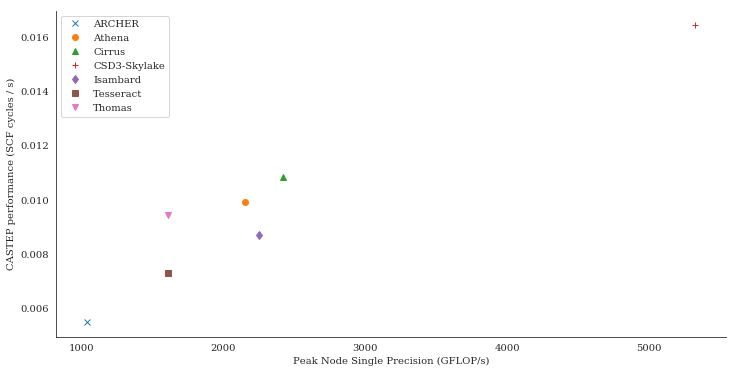

In [37]:
n=0
for system in systems:
    if system in peak_bw:
        plt.plot(peak_fp.get(system,0.0),castep_perf.get(system,0.0),marker_a[n],label=system)
        n += 1
plt.xlabel('Peak Node Single Precision (GFLOP/s)')
plt.ylabel('CASTEP performance (SCF cycles / s)')
plt.legend(loc='best')
sns.despine()
plt.savefig('castep_corr_fp.png', dpi=300)
print('\nCorrelation to single precision GFLOP/s:')
print('Pearson correlation coefficient = ', '{:.3f}'.format(stats.pearsonr(castep_perf_a, fp_perf_a)[0]))
print('Spearman rank-order correlation coefficient = ', '{:.3f}'.format(stats.spearmanr(castep_perf_a, fp_perf_a)[0]))
print('\nCorrelation to single precision FLOP/cycle:')
print('Pearson correlation coefficient = ', '{:.3f}'.format(stats.pearsonr(castep_perf_a, flops_a)[0]))
print('Spearman rank-order correlation coefficient = ', '{:.3f}'.format(stats.spearmanr(castep_perf_a, flops_a)[0]))

These analyses suggest a strong correlation between the peak floating point performance of the compute nodes and the performance of the CASTEP benchmark. The correlation for this CASTEP benchmark is stronger than the correlation for GROMACS; which is traditionally though of a pure floating point application. This is probably due to the fact that, on a single node, most of the time for this CASTEP benchmark is spent in LAPACK numerical routines which are well-optimed to exploit the maximum floating point performance from the processors. The systems furthest from the correlation line are:

-   Isambard (Marvell Arm ThunderX2) performs worse than expected given the peak floating point performance impying that this system is not exploiting the floating point performance as well as the other systems.
-   Thomas (Intel Xeon Broadwell) performs better than expected given the peak flaoting point performance.

### Correlation to peak memory performance

Below we compute the correlation coefficients for the CASTEP benchmark performance compared to memory performance, both in terms of peak bandwdth and in terms of the number of memory channels. As for the floating point correlation analysis, we perform two correlation tests: a Pearson correlation test and a Spearman rank-order correlation test.

In [38]:
print('Pearson correlation coefficient = ', '{:.3f}'.format(stats.pearsonr(castep_bw_a, peak_bw_a)[0]))
print('Spearman rank-order correlation coefficient = ', '{:.3f}'.format(stats.spearmanr(castep_bw_a, peak_bw_a)[0]))

Pearson correlation coefficient =  0.206
Spearman rank-order correlation coefficient =  -0.036


In [39]:
print('Pearson correlation coefficient = ', '{:.3f}'.format(stats.pearsonr(castep_bw_a, channels_a)[0]))
print('Spearman rank-order correlation coefficient = ', '{:.3f}'.format(stats.spearmanr(castep_bw_a, channels_a)[0]))

Pearson correlation coefficient =  0.135
Spearman rank-order correlation coefficient =  -0.060


The results for memory correlation suggest there is no correlation between node memory performance and the perfomance of this CASTEP benchmark on a single node.

### Performance comparison matrix

In [40]:
print("{:13s}".format(''),end='')
for jsystem in systems:
    print("{:>14s}".format(jsystem), end='')
print()
for isystem in systems:
    print("{:13s}".format(isystem), end='')
    iperf = castep_perf[isystem]
    for jsystem in systems:
        jperf = castep_perf[jsystem]
        print("{:14.3f}".format(iperf/jperf), end='')
    print()

                     ARCHER        Athena        Cirrus  CSD3-Skylake      Isambard     Tesseract        Thomas
ARCHER                1.000         0.555         0.508         0.336         0.632         0.755         0.583
Athena                1.802         1.000         0.915         0.605         1.139         1.361         1.051
Cirrus                1.969         1.092         1.000         0.661         1.244         1.486         1.149
CSD3-Skylake          2.977         1.652         1.512         1.000         1.881         2.248         1.737
Isambard              1.582         0.878         0.804         0.532         1.000         1.195         0.923
Tesseract             1.324         0.735         0.673         0.445         0.837         1.000         0.773
Thomas                1.714         0.951         0.871         0.576         1.083         1.294         1.000


## OpenSBLI: Taylor-Green Vortex 512^3 benchmark

Details of the Taylor-Green Vortex 512^3 benchmark can be found in this repository at: https://github.com/hpc-uk/archer-benchmarks/tree/master/apps/OpenSBLI

Performance is measured in 'interations/s'. The total runtime and number of iterations are read directly from the OpenSBLI ouptut and these are used to compute the number of iterations per second.

In [41]:
from appanalysis import osbli

### Best performance per platform comparison

This section compares the best performaning configuration on a single node of each platform.

In [42]:
systems = ['ARCHER','Athena','Cirrus','CSD3-Skylake','Isambard','Tesseract','Thomas']

osbli_perf = {}

for system in systems:
    wdir = '../apps/OpenSBLI/TGV512ss/results/' + system
    filelist = filemanip.get_filelist(wdir, 'output_1node')
    sysdict = sysdetails[system]
    print('\n============================================================')
    print(sysdict['Name'])
    osbli_df = pd.DataFrame(osbli.create_df_list(filelist, sysdict['PCores']*sysdict['PPerNode']))
    nodes, perf_max = osbli.get_perf_stats(osbli_df, 'max', writestats=True)
    osbli_perf[system] = perf_max[0]
    print('\n============================================================')


ARCHER
                 Perf                               Count
                  min    median       max      mean   sum
Nodes Cores                                              
1     24     0.098877  0.099615  0.100009  0.099593     5


Athena
                 Perf                               Count
                  min    median       max      mean   sum
Nodes Cores                                              
1     28     0.102653  0.104152  0.104436  0.103921     5


Cirrus
                 Perf                               Count
                  min    median       max      mean   sum
Nodes Cores                                              
1     36     0.130198  0.134866  0.135301  0.134144     6


Peta4-Skylake
                 Perf                               Count
                  min    median       max      mean   sum
Nodes Cores                                              
1     32     0.169993  0.196108  0.197485  0.190305     5


Isambard
                 Pe

In [43]:
formath = "{:>15s} {:>15s} {:>15s}"
formatp = "{:>15s} {:>15.3f} {:>15.3f}"
print("Performance improvement relative to ARCHER:\n")
print(formath.format('System', 'Perf. (iter/s)', 'Improvement'))
print(formath.format('======', '==============', '==========='))
aperf = osbli_perf.get('ARCHER',0.0)
osbli_perf_a = []
fp_perf_a = []
flops_a = []
osbli_bw_a = []
peak_bw_a = []
channels_a = []
for system in systems:
    tperf = osbli_perf.get(system,0.0)
    print(formatp.format(sysdetails[system]['Name'], tperf, tperf/aperf))
    if system in peak_fp:
        osbli_perf_a.append(osbli_perf.get(system,0.0))
        fp_perf_a.append(peak_fp.get(system,0.0))
        flops_a.append(flops.get(system,0.0))
    if system in peak_bw:
        osbli_bw_a.append(osbli_perf.get(system,0.0))
        peak_bw_a.append(peak_bw.get(system,0.0))
        channels_a.append(channels.get(system,0.0))

Performance improvement relative to ARCHER:

         System  Perf. (iter/s)     Improvement
         ======  ==============     ===========
         ARCHER           0.100           1.000
         Athena           0.104           1.044
         Cirrus           0.135           1.353
  Peta4-Skylake           0.197           1.975
       Isambard           0.191           1.911
      Tesseract           0.097           0.972
         Thomas           0.065           0.654


### Correlation to peak floating point performance

Below we compute the correlation coefficients for the OpenSBLI benchmark performance compared to peak floating point performance. We perform two correlation tests: a Pearson correlation test to measure the correlation between numerical floating point performance and OpenSBLI performance; and a Spearman rank-order correlation test to measure the correlation between the order of floating point performance and OpenSBLI performance.


Correlation to single precision GFLOP/s:
Pearson correlation coefficient =  0.741
Spearman rank-order correlation coefficient =  0.847

Correlation to single precision FLOP/cycle:
Pearson correlation coefficient =  0.345
Spearman rank-order correlation coefficient =  0.179


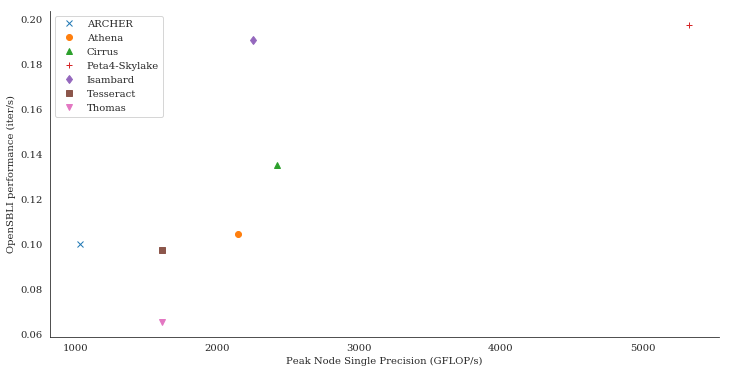

In [44]:
n=0
for system in systems:
    if system in peak_fp:
        plt.plot(peak_fp.get(system,0.0),osbli_perf.get(system,0.0),marker_a[n],label=sysdetails[system]['Name'])
        n += 1
plt.xlabel('Peak Node Single Precision (GFLOP/s)')
plt.ylabel('OpenSBLI performance (iter/s)')
plt.legend(loc='best')
sns.despine()
plt.savefig('osbli_corr_fp.png', dpi=300)
print('\nCorrelation to single precision GFLOP/s:')
print('Pearson correlation coefficient = ', '{:.3f}'.format(stats.pearsonr(osbli_perf_a, fp_perf_a)[0]))
print('Spearman rank-order correlation coefficient = ', '{:.3f}'.format(stats.spearmanr(osbli_perf_a, fp_perf_a)[0]))
print('\nCorrelation to single precision FLOP/cycle:')
print('Pearson correlation coefficient = ', '{:.3f}'.format(stats.pearsonr(osbli_perf_a, flops_a)[0]))
print('Spearman rank-order correlation coefficient = ', '{:.3f}'.format(stats.spearmanr(osbli_perf_a, flops_a)[0]))

This indicates that there is good correlation between OpenSBLI benchmark performance and floating point performance. The main outliers are:

- the Isambard system which sees much greater OpenSBLI performance than we would expect based on its floating point performance alone
- the Thomas system which sees much poorer peformance than we would expect based on its floating point performance alone

If we drop these two outliers, the correlation is much stronger:


Correlation to single precision GFLOP/s:
Pearson correlation coefficient =  0.968
Spearman rank-order correlation coefficient =  0.900

Correlation to single precision FLOP/cycle:
Pearson correlation coefficient =  0.907
Spearman rank-order correlation coefficient =  0.671


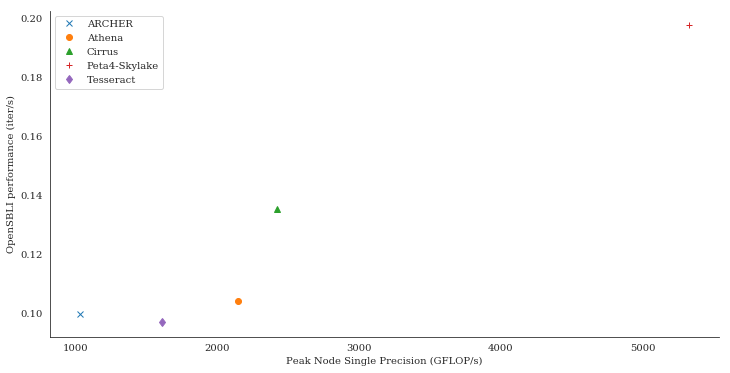

In [45]:
systems = ['ARCHER','Athena','Cirrus','CSD3-Skylake','Tesseract']
osbli_perf_a = []
fp_perf_a = []
flops_a = []
for system in systems:
    if system in peak_fp:
        osbli_perf_a.append(osbli_perf.get(system,0.0))
        fp_perf_a.append(peak_fp.get(system,0.0))
        flops_a.append(flops.get(system,0.0))
n=0
for system in systems:
    if system in peak_fp:
        plt.plot(peak_fp.get(system,0.0),osbli_perf.get(system,0.0),marker_a[n],label=sysdetails[system]['Name'])
        n += 1
plt.xlabel('Peak Node Single Precision (GFLOP/s)')
plt.ylabel('OpenSBLI performance (iter/s)')
plt.legend(loc='best')
sns.despine()
plt.savefig('osbli_corr_fp_nooutlier.png', dpi=300)
print('\nCorrelation to single precision GFLOP/s:')
print('Pearson correlation coefficient = ', '{:.3f}'.format(stats.pearsonr(osbli_perf_a, fp_perf_a)[0]))
print('Spearman rank-order correlation coefficient = ', '{:.3f}'.format(stats.spearmanr(osbli_perf_a, fp_perf_a)[0]))
print('\nCorrelation to single precision FLOP/cycle:')
print('Pearson correlation coefficient = ', '{:.3f}'.format(stats.pearsonr(osbli_perf_a, flops_a)[0]))
print('Spearman rank-order correlation coefficient = ', '{:.3f}'.format(stats.spearmanr(osbli_perf_a, flops_a)[0]))

### Correlation to peak memory performance

Below we compute the correlation coefficients for the OpenSBLI benchmark performance compared to memory performance, both in terms of peak bandwdth and in terms of the number of memory channels. As for the floating point correlation analysis, we perform two correlation tests: a Pearson correlation test and a Spearman rank-order correlation test.

In [46]:
systems = ['ARCHER','Athena','Cirrus','CSD3-Skylake','Isambard','Tesseract','Thomas']
print('Pearson correlation coefficient = ', '{:.3f}'.format(stats.pearsonr(osbli_bw_a, peak_bw_a)[0]))
print('Spearman rank-order correlation coefficient = ', '{:.3f}'.format(stats.spearmanr(osbli_bw_a, peak_bw_a)[0]))

Pearson correlation coefficient =  0.064
Spearman rank-order correlation coefficient =  -0.143


Pearson correlation coefficient =  0.709
Spearman rank-order correlation coefficient =  0.478


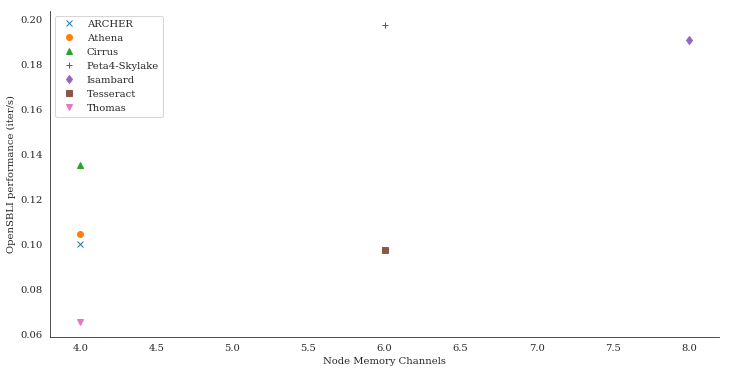

In [47]:
n=0
for system in systems:
    if system in peak_bw:
        plt.plot(channels.get(system,0.0),osbli_perf.get(system,0.0),marker_a[n],label=sysdetails[system]['Name'])
        n += 1
plt.xlabel('Node Memory Channels')
plt.ylabel('OpenSBLI performance (iter/s)')
plt.legend(loc='best')
sns.despine()
plt.savefig('osbli_corr_memchan.png', dpi=300)
print('Pearson correlation coefficient = ', '{:.3f}'.format(stats.pearsonr(osbli_bw_a, channels_a)[0]))
print('Spearman rank-order correlation coefficient = ', '{:.3f}'.format(stats.spearmanr(osbli_bw_a, channels_a)[0]))

These results indicate that there is no real correlation between memory bandwidth and OpenSBLI benchmark performance. There is more correlation between number of memory channels and performance but it is still not strong.

### Performance comparison matrix

In [48]:
systems = ['ARCHER','Athena','Cirrus','CSD3-Skylake','Isambard','Tesseract','Thomas']
print("{:13s}".format(''),end='')
for jsystem in systems:
    print("{:>14s}".format(jsystem), end='')
print()
for isystem in systems:
    print("{:13s}".format(isystem), end='')
    iperf = osbli_perf[isystem]
    for jsystem in systems:
        jperf = osbli_perf[jsystem]
        print("{:14.3f}".format(iperf/jperf), end='')
    print()

                     ARCHER        Athena        Cirrus  CSD3-Skylake      Isambard     Tesseract        Thomas
ARCHER                1.000         0.958         0.739         0.506         0.523         1.029         1.530
Athena                1.044         1.000         0.772         0.529         0.546         1.074         1.598
Cirrus                1.353         1.296         1.000         0.685         0.708         1.392         2.070
CSD3-Skylake          1.975         1.891         1.460         1.000         1.033         2.031         3.021
Isambard              1.911         1.830         1.413         0.968         1.000         1.966         2.924
Tesseract             0.972         0.931         0.719         0.492         0.509         1.000         1.488
Thomas                0.654         0.626         0.483         0.331         0.342         0.672         1.000


## GROMACS: 1400k Atom Benchmark

Details of the 1400k benchmark can be found in this repository at:  https://github.com/hpc-uk/archer-benchmarks/tree/master/apps/GROMACS

Performance is measured in 'ns/day'. This is calculated by the GROMACS software itself and is read directly from the GROMACS output.

In [49]:
from appanalysis import gromacs

### Best performance per platform comparison


This section compares the best performaning configuration on a single node of each platform.

In [50]:
systems = ['ARCHER','Athena','Cirrus','CSD3-Skylake','Isambard','Tesseract','Thomas','CSD3-GPU']
perf = {}
notes = {}

for system in systems:
    wdir = '../apps/GROMACS/1400k-atoms/results/' + system
    filelist = filemanip.get_filelist(wdir, 'benchmark_1nodes')
    sysdict = sysdetails[system]
    print('\n============================================================')
    print(sysdict['Name'])
    gromacs_df = pd.DataFrame(gromacs.create_df_list(filelist, sysdict['PCores']*sysdict['PPerNode']))
    nodes, perf_max = gromacs.get_perf_stats(gromacs_df, 'max', writestats=True)
    perf[system] = perf_max[0]
    print('\n============================================================')


# JADE performance result is taken from the runs by HEC BioSim
systems.append('JADE')
perf['JADE'] = 1.647
notes['JADE'] = '(5 core, 1 GPU), http://www.hecbiosim.ac.uk/jade-benchmarks'



ARCHER
                      Perf                       Count
                       min median    max    mean   sum
Nodes Cores Threads                                   
1     24    1        1.025  1.037  1.049  1.0370     2
      48    2        1.199  1.199  1.216  1.2024     5


Athena
                      Perf                          Count
                       min  median    max      mean   sum
Nodes Cores Threads                                      
1     28    1        1.270  1.2705  1.276  1.271667     6
      56    2        1.527  1.5290  1.531  1.529000     5


Cirrus
                      Perf                         Count
                       min median    max      mean   sum
Nodes Cores Threads                                     
1     36    1        1.632  1.632  1.636  1.633333     3
      72    2        1.699  1.899  1.918  1.862600     5


Peta4-Skylake
                      Perf                        Count
                       min  median    max    mean   

GPU GFLOP/s and FLOPS/cycle are computed as (number of GPUs used) &times; (GPU single precision GFLOP/s or FLOPS/cycle reference value
[ref](https://www.nvidia.com/en-us/data-center/tesla-p100/)).

In [51]:
systems = ['ARCHER','Athena','Cirrus','CSD3-Skylake','Isambard','Tesseract','Thomas','CSD3-GPU','JADE']

# Add appropriate GPU FP performance for GPU systems
peak_fp['CSD3-GPU'] = peak_fp['CSD3-GPU'] + (4 * sysdetails['CSD3-GPU']['AFLOPs'])
peak_fp['JADE'] = peak_fp['JADE'] + (1 * sysdetails['JADE']['AFLOPs'])

# Each NVidia P100 has 56 Streaming Multiprocessors each of which gives 128 SP FLOP/cycle = 7168 SP FLOP/cycle per GPU
flops['CSD3-GPU'] = flops['CSD3-GPU'] + (4 * 7168)
flops['JADE'] = flops['JADE'] + (1 * 7168)

formath = "{:>15s} {:>15s} {:>15s}"
formatp = "{:>15s} {:>15.3f} {:>15.3f} {:s}"
print("Performance improvement relative to ARCHER:\n")
print(formath.format('System', 'Perf. (ns/day)', 'Improvement'))
print(formath.format('======', '==============', '==========='))
gmx_perf_a = []
fp_perf_a = []
flops_a = []
gmx_bw_a = []
peak_bw_a = []
channels_a = []
for system in systems:
    sysdict = sysdetails[system]
    tperf = perf.get(system,0.0)
    print(formatp.format(sysdict['Name'], tperf, tperf/perf['ARCHER'], notes.get(system, '')))
    if system in peak_fp:
        gmx_perf_a.append(perf.get(system,0.0))
        fp_perf_a.append(peak_fp.get(system,0.0))
        flops_a.append(flops.get(system,0.0))
    if system in peak_bw:
        gmx_bw_a.append(perf.get(system,0.0))
        peak_bw_a.append(peak_bw.get(system,0.0))
        channels_a.append(channels.get(system,0.0))
    

Performance improvement relative to ARCHER:

         System  Perf. (ns/day)     Improvement
         ======  ==============     ===========
         ARCHER           1.216           1.000 
         Athena           1.531           1.259 
         Cirrus           1.918           1.577 
  Peta4-Skylake           2.503           2.058 
       Isambard           1.250           1.028 
      Tesseract           1.326           1.090 
         Thomas           1.237           1.017 
    Wilkes2-GPU           2.963           2.437 
           JADE           1.647           1.354 (5 core, 1 GPU), http://www.hecbiosim.ac.uk/jade-benchmarks


### Correlation to peak floating point performance

Below we compute the correlation coefficients for the GROMACS benchmark performance compared to peak floating point performance. We perform two correlation tests: a Pearson correlation test to measure the correlation between numerical floating point performance and GROMACS performance; and a Spearman rank-order correlation test to measure the correlation between the order of floating point performance and GROMACS performance.


Correlation to single precision GFLOP/s:
Pearson correlation coefficient =  0.776
Spearman rank-order correlation coefficient =  0.887

Correlation to single precision FLOP/cycle:
Pearson correlation coefficient =  0.729
Spearman rank-order correlation coefficient =  0.822


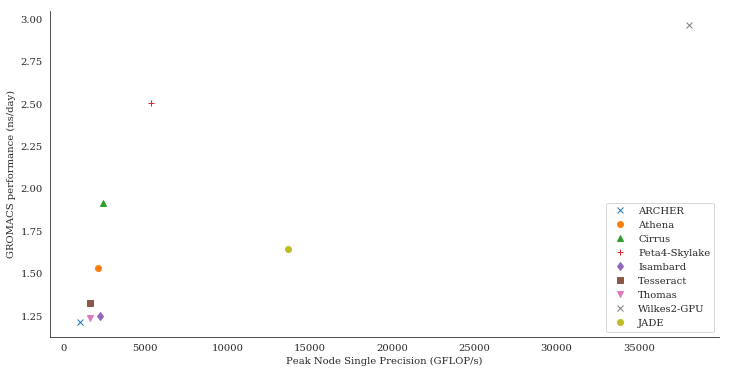

In [52]:
n=0
for system in systems:
    if system in peak_fp:
        plt.plot(peak_fp.get(system,0.0),perf.get(system,0.0),marker_a[n],label=sysdetails[system]['Name'])
        n += 1
plt.xlabel('Peak Node Single Precision (GFLOP/s)')
plt.ylabel('GROMACS performance (ns/day)')
plt.legend(loc='best')
sns.despine()
plt.savefig('gromacs_corr_fp.png', dpi=300)
print('\nCorrelation to single precision GFLOP/s:')
print('Pearson correlation coefficient = ', '{:.3f}'.format(stats.pearsonr(gmx_perf_a, fp_perf_a)[0]))
print('Spearman rank-order correlation coefficient = ', '{:.3f}'.format(stats.spearmanr(gmx_perf_a, fp_perf_a)[0]))
print('\nCorrelation to single precision FLOP/cycle:')
print('Pearson correlation coefficient = ', '{:.3f}'.format(stats.pearsonr(gmx_perf_a, flops_a)[0]))
print('Spearman rank-order correlation coefficient = ', '{:.3f}'.format(stats.spearmanr(gmx_perf_a, flops_a)[0]))

Both the Pearson and Spearman rank-order correlation coefficients are high indicating that the GROMACS benchmark performance is strongly correlated to single preciaion floating point performance of the compute resources used.

#### CPU systems only
Correlation not including GPU systems.


Correlation to single precision GFLOP/s:
Pearson correlation coefficient =  0.924
Spearman rank-order correlation coefficient =  0.865

Correlation to single precision FLOP/cycle:
Pearson correlation coefficient =  0.879
Spearman rank-order correlation coefficient =  0.777


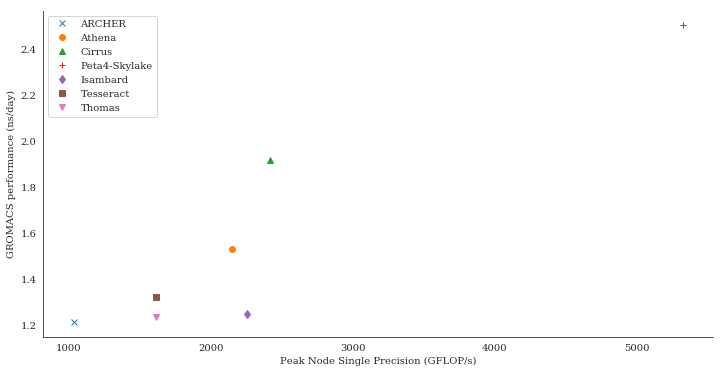

In [53]:
n=0
for system in systems[:-2]:
    if system in peak_fp:
        plt.plot(peak_fp.get(system,0.0),perf.get(system,0.0),marker_a[n],label=sysdetails[system]['Name'])
        n += 1
plt.xlabel('Peak Node Single Precision (GFLOP/s)')
plt.ylabel('GROMACS performance (ns/day)')
plt.legend(loc='best')
sns.despine()
plt.savefig('gromacs_corr_fp_cpu.png', dpi=300)
print('\nCorrelation to single precision GFLOP/s:')
print('Pearson correlation coefficient = ', '{:.3f}'.format(stats.pearsonr(gmx_perf_a[:-2], fp_perf_a[:-2])[0]))
print('Spearman rank-order correlation coefficient = ', '{:.3f}'.format(stats.spearmanr(gmx_perf_a[:-2], fp_perf_a[:-2])[0]))
print('\nCorrelation to single precision FLOP/cycle:')
print('Pearson correlation coefficient = ', '{:.3f}'.format(stats.pearsonr(gmx_perf_a[:-2], flops_a[:-2])[0]))
print('Spearman rank-order correlation coefficient = ', '{:.3f}'.format(stats.spearmanr(gmx_perf_a[:-2], flops_a[:-2])[0]))

We can see that if we exclude the GPU systems from the correlation analysis the correlation between performance and floating point performance is even stronger. The Isambard performance is the outlying value as this system does not seem to achieve the GROMACS performance expected from its peak floating point performance.

### Correlation to peak memory performance

Below we compute the correlation coefficients for the GROMACS benchmark performance compared to peak floating point performance. We perform two correlation tests: a Pearson correlation test to measure the correlation between numerical floating point performance and GROMACS performance; and a Spearman rank-order correlation test to measure the correlation between the order of floating point performance and GROMACS performance.

In [54]:
print('Pearson correlation coefficient = ', '{:.3f}'.format(stats.pearsonr(gmx_bw_a, peak_bw_a)[0]))
print('Spearman rank-order correlation coefficient = ', '{:.3f}'.format(stats.spearmanr(gmx_bw_a, peak_bw_a)[0]))

Pearson correlation coefficient =  0.152
Spearman rank-order correlation coefficient =  0.107


In [55]:
print('Pearson correlation coefficient = ', '{:.3f}'.format(stats.pearsonr(gmx_bw_a, channels_a)[0]))
print('Spearman rank-order correlation coefficient = ', '{:.3f}'.format(stats.spearmanr(gmx_bw_a, channels_a)[0]))

Pearson correlation coefficient =  0.024
Spearman rank-order correlation coefficient =  0.179


This analysis confirms that there is no obvious correlation between the GROMACS benchmark performance and the memory performance (in terms of bandwidth or number of memory channels). This is as expected as, for this benchmark, we would not expect GROMACS to be dependent on on memory performance.

### Performance comparison matrix

In [56]:
print("{:13s}".format(''),end='')
for jsystem in systems:
    print("{:>14s}".format(sysdetails[jsystem]['Name']), end='')
print()
for isystem in systems:
    print("{:13s}".format(sysdetails[isystem]['Name']), end='')
    for jsystem in systems:
        print("{:14.3f}".format(perf[isystem]/perf[jsystem]), end='')
    print()

                     ARCHER        Athena        Cirrus Peta4-Skylake      Isambard     Tesseract        Thomas   Wilkes2-GPU          JADE
ARCHER                1.000         0.794         0.634         0.486         0.973         0.917         0.983         0.410         0.738
Athena                1.259         1.000         0.798         0.612         1.225         1.155         1.238         0.517         0.930
Cirrus                1.577         1.253         1.000         0.766         1.534         1.446         1.551         0.647         1.165
Peta4-Skylake         2.058         1.635         1.305         1.000         2.002         1.888         2.023         0.845         1.520
Isambard              1.028         0.816         0.652         0.499         1.000         0.943         1.011         0.422         0.759
Tesseract             1.090         0.866         0.691         0.530         1.061         1.000         1.072         0.448         0.805
Thomas              